# Ethogram analysis

In this notebook we will use the DLC tracking to categorize behaviour from the object space task in different states. States definition uses the following information.

1. Navigation : animal is far away from the object (circle defined as 200px radious) and running at speed > 2cm/s
2. Resting    : animal is far away from the object circle defined as 200px radious and speed < 2cm/s
3. Exploring  : animal is close to object (with a big radius of 200px) and is inspecting it, or it is at a closer distance (radius < 100 px) 
4. Inspection : animal is looking at the object (angle between head direction and object direcction < 45')

Exploting and inspection can be divided in the different objects the animal is looking at, given by the positions of the objects.

1. LL : lower left object
2. LR : Lower right object
3. UL : uper left object
4. UR : uper right object

Now, we will define :

1. Resting outside arena.
2. Resting inside arena : far away from object and speed < 50px/s
3. Navigation : far way from object and speed > 50px/s and the animal is not looking at the object.
4. Running towards object: speed is >50px/s and animal is looking at object.
5. Exploring object X: animal is either to close to the object (<75 px) or speed is small (<50px/s ) and distance to object is < 200 px and the animal is looking at the object.

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
cmap = cm.jet

In [19]:
## Here define al characteristics relevant to which mouse, session and trial is analyzed

mouse = 32363        ### mouse number id
session_now =1              ## session that will run
day = 0
re_sf = 20
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [20]:
session = session_now
behaviour_dir = os.environ['PROJECT_DIR'] + 'data/ethogram/' + f'{mouse}' + '/session_' + f'{session}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'figures/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'data/timeline/'

In [37]:
session = session_now
behaviour = []
total_time = 0
for day in [1,2,3,4]:
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour.append(np.load(behaviour_dir + beh_file_name_1))
    total_time = total_time + behaviour[day-1].shape[0]
    #c = np.linspace(0, 20, len(behaviour))
    #reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    #resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
labels = [' ', 'Rest0','Rest1', 'Running', 'Running2', 'Exploring']

## LOAD ENVIRONMENTAL CONDITIONS
condition_objects_file = objects_dir + 'condition_vector_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
condition_vector = np.load(condition_objects_file)

## LOAD TIMELINE
time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{1}'+'.4.'+f'{1}'+\
                          '.'+f'{0}'+ '.pkl'

timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
timeline_info = pickle.load(timeline_file)
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = behaviour[0].shape[0]
timeline = timeline_1/re_sf
time_lenght = 40

In [71]:
behaviour_all = np.zeros((total_time,1))
start = 0
for day in range(4):
    behaviour_all[start:start+behaviour[day].shape[0]] = behaviour[day]
    start = start + behaviour[day].shape[0]


array([0.])

In [64]:
#time spent in an object
behavioural_matrix = np.zeros((4,42))
for day in [0,1,2,3]:
    for trial_it in range(5):
        trial = 2*(day*5 + trial_it)
        for target in [1,2,3,4]:
            position_events = np.where(behaviour_all[int(timeline_1[trial]):int(timeline_1[trial+1])] == target)[0]
            behavioural_matrix[target-2,trial] = len(position_events)/10

#number of visits
behavioural_number = np.zeros((4,42))
for day in range(4):
    for trial_it in range(5):
        trial = 2*(day*5+ trial_it)
        short_vector = behaviour_all[int(timeline_1[trial]):int(timeline_1[trial+1])]
        events_list = []
        events_counter_list = []
        start_counter = 100
        counter = 0
        for i in range(len(short_vector)):
            if short_vector[i] != start_counter:
                events_list.append(start_counter)
                events_counter_list.append(counter)
                start_counter = short_vector[i]
                counter = 1
            else:
                counter = counter + 1
        events = np.array(events_list)
        events_counter = np.array(events_counter_list)           #counter in frames un the original sampling rate
        for target in [1,2,3,4]:
            position_events = np.where(events == target)[0]
            behavioural_number[target-2,trial] = len(position_events)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.


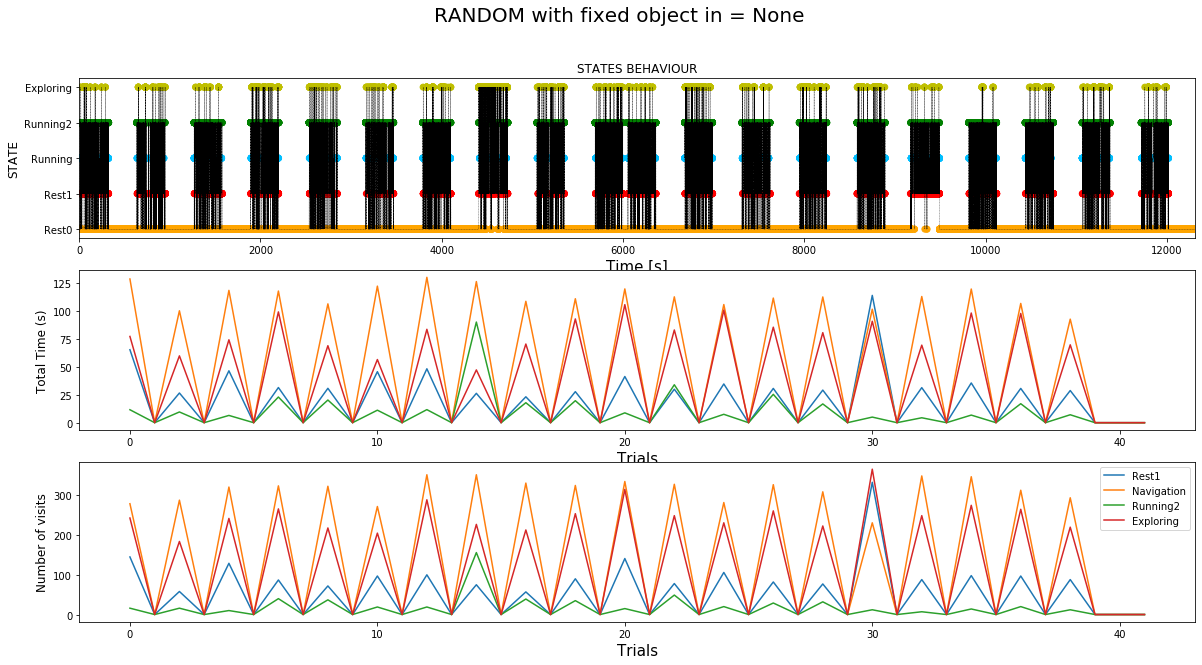

In [101]:


figure = plt.figure(constrained_layout=True)
gs = plt.GridSpec(3, 1)

colornames=["r","deepskyblue","g","y","orange"]
colors=[]
for i in ethogram:
    colors.append(colornames[int(i)-1])

axes1 = figure.add_subplot(gs[0, 0])
axes1.scatter(np.arange(0,len(behaviour_all))/10,behaviour_all,c=colors)
axes1.plot(np.arange(0,len(behaviour_all))/10,behaviour_all,linestyle="--",c="k",linewidth=0.3)

axes1.set_yticklabels(labels)
axes1.set_xlabel('Time [s]', fontsize = 15)
axes1.set_xlim([0,len(behaviour_all)/10])
axes1.set_ylabel('STATE', fontsize = 12)
axes1.set_title('STATES BEHAVIOUR')

conditions =['Rest1', 'Navigation', 'Running2','Exploring']
axes2 = figure.add_subplot(gs[1, 0])
#x = axes2.imshow(behavioural_matrix)
axes2.plot(behavioural_matrix.T)
#axes2.set_yticks(np.arange(len(conditions)))
#axes2.set_yticklabels(conditions)
axes2.set_xlabel('Trials', fontsize = 15)
axes2.set_ylabel('Total Time (s)', fontsize = 12)
#axes2.set_title('State Time')
#axes2.set_xlim([0,time_lenght])

#figure.colorbar(x, ax =axes2)

axes3 = figure.add_subplot(gs[2, 0])
axes3.plot(behavioural_number.T)
#axes3.set_yticks(np.arange(len(conditions)))
#axes3.set_yticklabels(conditions)
axes3.set_xlabel('Trials', fontsize = 15)
axes3.set_ylabel('Number of visits', fontsize = 12)
axes3.legend(conditions)
#axes3.set_xlim([0,time_lenght])
#axes3.set_title('State number of visits')


#figure.colorbar(x, ax = axes3)

#figure.colorbar(x, ax =[axes1,axes2,axes3])
figure.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
figure.set_size_inches(20,10)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_exploratory_vector.png'
figure.savefig(figure_path + figure_name)

In [84]:
events_list = []
events_counter_list = []
start_counter = 100
counter = 0
for i in range(len(behaviour_all)):
    if behaviour_all[i] != start_counter:
        events_list.append(start_counter)
        events_counter_list.append(counter)
        start_counter = behaviour_all[i]
        counter = 1
    else:
        counter = counter + 1

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  app.launch_new_instance()


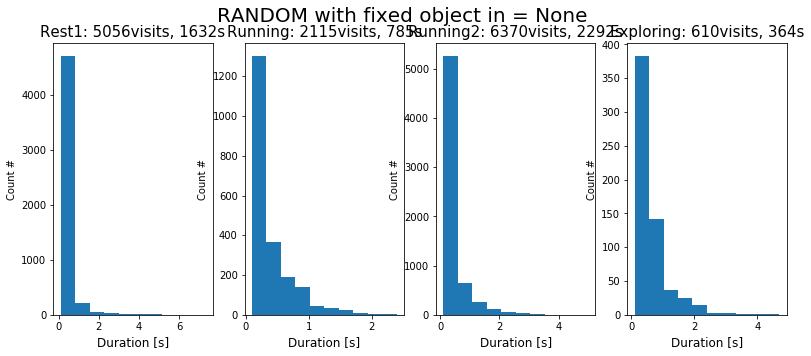

In [85]:
fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(1, 6)
events = np.array(events_list)
events_counter = np.array(events_counter_list)           #counter in frames un the original sampling rate
for target in [1,2,3,4]:
    position_events = np.where(events == target)[0]
    events_duration = events_counter[position_events]/10   # convert to seconds
    ax = fig.add_subplot(gs[0, target])
    ax.hist(events_duration)
    ax.set_title(labels[target+1] +': '+ f'{len(position_events)}' +'visits, ' + f'{int(sum(events_duration))}' + 's' ,fontsize = 15)
    ax.set_xlabel('Duration [s]',fontsize = 12)
    ax.set_ylabel('Count #')
fig.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
fig.set_size_inches(20, 5)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_exploratory_statistics.png'
fig.savefig(figure_path + figure_name)



In [56]:
# create exploration events vectors that are shorter or longer that 15s

limit = 10 # 200 frames = 10 s
behaviour_short_events = np.zeros(behaviour.shape)
behaviour_long_events = np.zeros(behaviour.shape)

start = 0
for i in range(len(events)):
    if events_counter[i] < limit:
        behaviour_short_events[int(start):int(start+events_counter[i])] = events[i]
    else:
        behaviour_long_events[int(start):int(start+events_counter[i])] = events[i]
    start = start + events_counter[i]


In [57]:
beh_file_short = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_short.npy'
beh_file_long = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_long.npy'

np.save(behaviour_dir + beh_file_short,behaviour_short_events)
np.save(behaviour_dir + beh_file_long,behaviour_long_events)

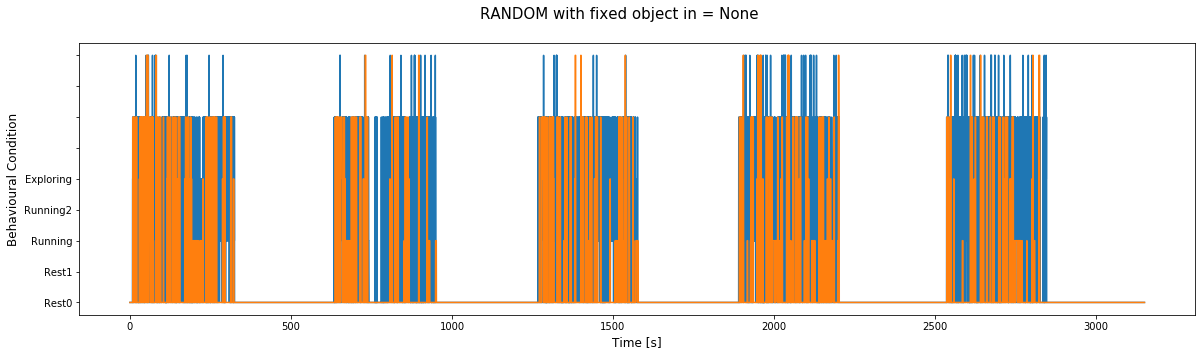

In [58]:
figure, axes = plt.subplots(1)
axes.plot(np.arange(0,len(behaviour))/10,behaviour_short_events)
axes.plot(np.arange(0,len(behaviour))/10,behaviour_long_events)
#axes.plot(np.arange(0,len(behaviour))/10,behaviour)
axes.set_yticklabels(labels)
axes.set_xlabel('Time [s]', fontsize = 12)
axes.set_ylabel('Behavioural Condition', fontsize = 12)
figure.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 15)
figure.set_size_inches(20,5)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_exploratory_lenght.png'
figure.savefig(figure_path + figure_name)